In [1]:
import pandas as pd
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn import metrics

def printmd(string):
    display(Markdown(string))
    
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

import utils
from scipy import optimize
import os

%matplotlib inline

In [2]:
#adult = pd.read_csv('adult.csv')

column_names = ['age', 'workclass', 'fnlwgt', 'education', 'educational_num','marital_status', 'occupation', 'relationship', 'race', 'gender','capital_gain', 'capital_loss', 'hours_per_week', 'native_country','income']

train = pd.read_csv('adult_data.csv', sep=",\s", header=None, names = column_names, engine = 'python')
test = pd.read_csv('adult_test.csv', sep=",\s", header=None, names = column_names, engine = 'python')
test['income'].replace(regex=True,inplace=True,to_replace=r'\.',value=r'')

adult = pd.concat([test,train])
adult.reset_index(inplace = True, drop = True)

In [3]:
# Setting all the categorical columns to type category
for col in set(adult.columns) - set(adult.describe().columns):
    adult[col] = adult[col].astype('category')
    
printmd('## 1.1. Columns and their types')
print(adult.info())

## 1.1. Columns and their types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              48842 non-null  int64   
 1   workclass        48842 non-null  category
 2   fnlwgt           48842 non-null  int64   
 3   education        48842 non-null  category
 4   educational_num  48842 non-null  int64   
 5   marital_status   48842 non-null  category
 6   occupation       48842 non-null  category
 7   relationship     48842 non-null  category
 8   race             48842 non-null  category
 9   gender           48842 non-null  category
 10  capital_gain     48842 non-null  int64   
 11  capital_loss     48842 non-null  int64   
 12  hours_per_week   48842 non-null  int64   
 13  native_country   48842 non-null  category
 14  income           48842 non-null  category
dtypes: category(9), int64(6)
memory usage: 2.7 MB
None


In [4]:
# Top 5 records
printmd('## 1.2. Data')
print(adult.head(5))

print('\n')

printmd('## 1.3. Summary Statistics')
adult.describe()

## 1.2. Data

   age  workclass  fnlwgt     education  educational_num      marital_status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18          ?  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital_gain  capital_loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours_per_week native_country incom

## 1.3. Summary Statistics

,age,fnlwgt,educational_num,capital_gain,capital_loss,hours_per_week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [5]:
printmd('## 1.4. Missing values')
for i,j in zip(adult.columns,(adult.values.astype(str) == '?').sum(axis = 0)):
    if j > 0:
        printmd(str(i) + ': ' + str(j) + ' records')

## 1.4. Missing values

workclass: 2799 records

occupation: 2809 records

native_country: 857 records

In [6]:
# Create one hot encoding of the categorical columns in the data frame.
def oneHotCatVars(df, df_cols):
    
    df_1 = adult_data = df.drop(columns = df_cols, axis = 1)
    df_2 = pd.get_dummies(df[df_cols])
    
    return (pd.concat([df_1, df_2], axis=1, join='inner'))

In [7]:
printmd('### 1.4.1. Filling in missing values for Attribute workclass')

test_data = adult[(adult.workclass.values == '?')].copy()
test_label = test_data.workclass

train_data = adult[(adult.workclass.values != '?')].copy()
train_label = train_data.workclass

test_data.drop(columns = ['workclass'], inplace = True)
train_data.drop(columns = ['workclass'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)

majority_class = adult.workclass.value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

adult.loc[(adult.workclass.values == '?'),'workclass'] = overall_pred.values
print(adult.workclass.value_counts())
print(adult.workclass.unique())

### 1.4.1. Filling in missing values for Attribute workclass

/home/r0731281/Anaconda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Private             35740
Self-emp-not-inc     3879
Local-gov            3137
State-gov            1981
Self-emp-inc         1695
Federal-gov          1435
Never-worked          954
Without-pay            21
?                       0
Name: workclass, dtype: int64
['Private', 'Local-gov', 'Never-worked', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay']
Categories (9, object): ['?', 'Federal-gov', 'Local-gov', 'Never-worked', ..., 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay']


In [8]:
printmd('### 1.4.2. Filling in missing values for Occupation occupation')

test_data = adult[(adult.occupation.values == '?')].copy()
test_label = test_data.occupation

train_data = adult[(adult.occupation.values != '?')].copy()
train_label = train_data.occupation

test_data.drop(columns = ['occupation'], inplace = True)
train_data.drop(columns = ['occupation'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)


majority_class = adult.occupation.value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

adult.loc[(adult.occupation.values == '?'),'occupation'] = overall_pred.values
print(adult.occupation.value_counts())
print(adult.occupation.unique())

### 1.4.2. Filling in missing values for Occupation occupation

/home/r0731281/Anaconda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Prof-specialty       7764
Craft-repair         6567
Exec-managerial      6138
Adm-clerical         5897
Sales                5582
Other-service        5107
Machine-op-inspct    3071
Transport-moving     2390
Handlers-cleaners    2092
Farming-fishing      1510
Tech-support         1460
Protective-serv       994
Priv-house-serv       255
Armed-Forces           15
?                       0
Name: occupation, dtype: int64
['Machine-op-inspct', 'Farming-fishing', 'Protective-serv', 'Adm-clerical', 'Other-service', ..., 'Sales', 'Priv-house-serv', 'Transport-moving', 'Handlers-cleaners', 'Armed-Forces']
Length: 14
Categories (15, object): ['?', 'Adm-clerical', 'Armed-Forces', 'Craft-repair', ..., 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving']


In [9]:
printmd('### 1.4.3. Filling in missing values for Native Country')

test_data = adult[(adult['native_country'].values == '?')].copy()
test_label = test_data['native_country']

train_data = adult[(adult['native_country'].values != '?')].copy()
train_label = train_data['native_country']

test_data.drop(columns = ['native_country'], inplace = True)
train_data.drop(columns = ['native_country'], inplace = True)

train_data = oneHotCatVars(train_data, train_data.select_dtypes('category').columns)
test_data = oneHotCatVars(test_data, test_data.select_dtypes('category').columns)

log_reg = LogisticRegression()
log_reg.fit(train_data, train_label)
log_reg_pred = log_reg.predict(test_data)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
clf_pred = clf.predict(test_data)

r_forest = RandomForestClassifier(n_estimators=10)
r_forest.fit(train_data, train_label)
r_forest_pred = r_forest.predict(test_data)

majority_class = adult['native_country'].value_counts().index[0]

pred_df =  pd.DataFrame({'RFor': r_forest_pred, 'DTree' : clf_pred, 'LogReg' : log_reg_pred})
overall_pred = pred_df.apply(lambda x: x.value_counts().index[0] if x.value_counts()[0] > 1 else majority_class, axis = 1)

adult.loc[(adult['native_country'].values == '?'),'native_country'] = overall_pred.values
print(adult['native_country'].value_counts())
print(adult['native_country'].unique())

### 1.4.3. Filling in missing values for Native Country

/home/r0731281/Anaconda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


United-States                 44646
Mexico                          956
Philippines                     302
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           155
Cuba                            138
China                           128
England                         127
South                           123
Jamaica                         107
Italy                           105
Dominican-Republic              104
Japan                            96
Vietnam                          89
Guatemala                        88
Poland                           87
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           67
Iran                             59
Greece                           49
Nicaragua                        49
Peru                             46
Ecuador                     

In [10]:
# Resetting the categories
adult['workclass'] = adult['workclass'].cat.remove_categories('?')
adult['occupation'] = adult['occupation'].cat.remove_categories('?')
adult['native_country'] = adult['native_country'].cat.remove_categories('?')

In [11]:
printmd('## 1.5. Correlation Matrix')

display(adult.corr())

printmd('We see that none of the columns are highly correlated.')

## 1.5. Correlation Matrix

,age,fnlwgt,educational_num,capital_gain,capital_loss,hours_per_week
age,1.000000,-0.076628,0.030940,0.077229,0.056944,0.071558
fnlwgt,-0.076628,1.000000,-0.038761,-0.003706,-0.004366,-0.013519
educational_num,0.030940,-0.038761,1.000000,0.125146,0.080972,0.143689
capital_gain,0.077229,-0.003706,0.125146,1.000000,-0.031441,0.082157
capital_loss,0.056944,-0.004366,0.080972,-0.031441,1.000000,0.054467
hours_per_week,0.071558,-0.013519,0.143689,0.082157,0.054467,1.000000


We see that none of the columns are highly correlated.

In [12]:
# Creating a dictionary that contain the education and it's corresponding education level
edu_level = {}
for x,y in adult[['educational_num','education']].drop_duplicates().itertuples(index=False):
    edu_level[y] = x

## 2.1. Education vs Income

I plot a bar graph showing the proportion of income classes across education levels         in the figure below. As one would expect, we see from the bar graph below that as the         education level increase, the proportion of people who earn more than 50k a year also         increase. It is interesting to note that only after a master's degree, the proportion of         people earning more than 50k a year, is a majority.

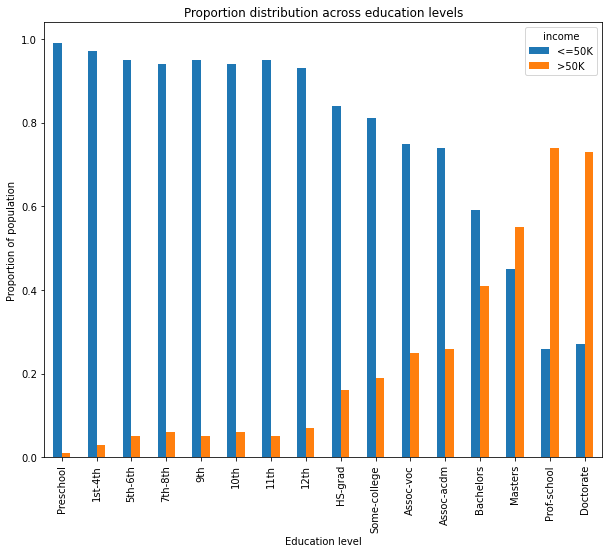

In [13]:
printmd('## 2.1. Education vs Income')

education = round(pd.crosstab(adult.education, adult.income).div(pd.crosstab(adult.education, adult.income).apply(sum,1),0),2)
education = education.reindex(sorted(edu_level, key=edu_level.get, reverse=False))

ax = education.plot(kind ='bar', title = 'Proportion distribution across education levels', figsize = (10,8))
ax.set_xlabel('Education level')
ax.set_ylabel('Proportion of population')

printmd('I plot a bar graph showing the proportion of income classes across education levels \
        in the figure below. As one would expect, we see from the bar graph below that as the \
        education level increase, the proportion of people who earn more than 50k a year also \
        increase. It is interesting to note that only after a master\'s degree, the proportion of \
        people earning more than 50k a year, is a majority.')

## 2.2 Gender vs Income

We plot a bar graph showing the proportion of income classes across the genders in figure         below. From the graph, at an overall view, there exists a wage gap between females and males.         Since we do not have the exactly value of the income, we are limited to only observing that the         proportion of males earning more than 50k a year is more than double of their female counterparts.         

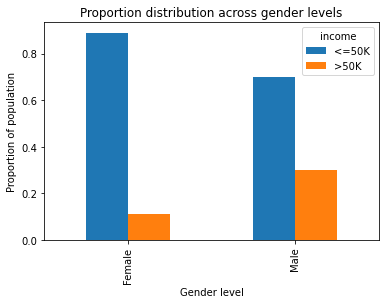

In [14]:
printmd('## 2.2 Gender vs Income')

gender = round(pd.crosstab(adult.gender, adult.income).div(pd.crosstab(adult.gender, adult.income).apply(sum,1),0),2)
gender.sort_values(by = '>50K', inplace = True)

ax = gender.plot(kind ='bar', title = 'Proportion distribution across gender levels')
ax.set_xlabel('Gender level')
ax.set_ylabel('Proportion of population')

printmd('We plot a bar graph showing the proportion of income classes across the genders in figure \
        below. From the graph, at an overall view, there exists a wage gap between females and males. \
        Since we do not have the exactly value of the income, we are limited to only observing that the \
        proportion of males earning more than 50k a year is more than double of their female counterparts. \
        ')

Taking a closer look at the disparity in income between men and women, plot the         proportion of men and women who earn more than 50k a year, across all the working         classes as seen in Fig. 3. We see that men always have a higher proportion earning         more than 50k a year than women, except for the 'without.pay' working class, where         they have the same proportion.

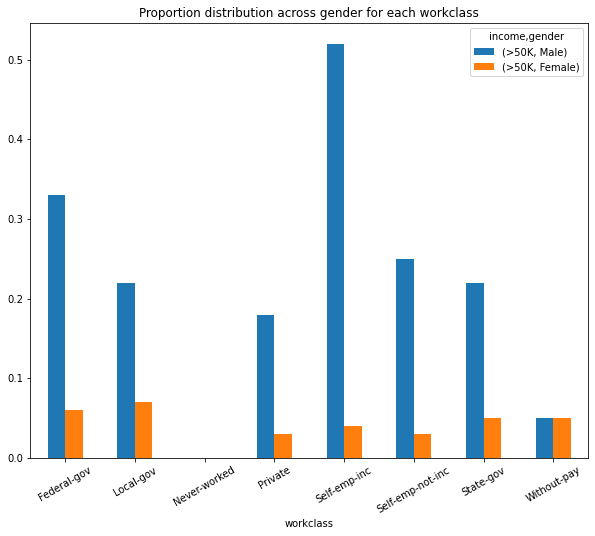

In [15]:

gender_workclass = round(pd.crosstab(adult.workclass, [adult.income, adult.gender]).div(pd.crosstab(adult.workclass, [adult.income, adult.gender]).apply(sum,1),0),2)
gender_workclass[[('>50K','Male'), ('>50K','Female')]].plot(kind = 'bar', title = 'Proportion distribution across gender for each workclass', figsize = (10,8), rot = 30)
ax.set_xlabel('Gender level')
ax.set_ylabel('Proportion of population')

printmd('Taking a closer look at the disparity in income between men and women, plot the \
        proportion of men and women who earn more than 50k a year, across all the working \
        classes as seen in Fig. 3. We see that men always have a higher proportion earning \
        more than 50k a year than women, except for the \'without.pay\' working class, where \
        they have the same proportion.')

## 2.3. Occupation vs Income

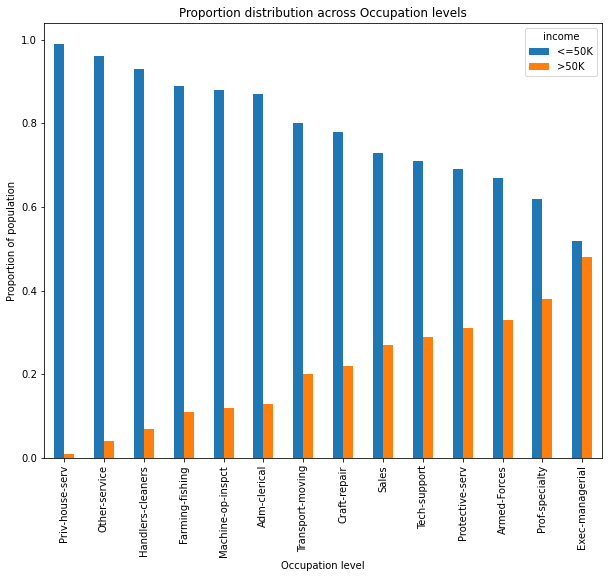

In [16]:
printmd('## 2.3. Occupation vs Income')

occupation = round(pd.crosstab(adult.occupation, adult.income).div(pd.crosstab(adult.occupation, adult.income).apply(sum,1),0),2)
occupation.sort_values(by = '>50K', inplace = True)

ax = occupation.plot(kind ='bar', title = 'Proportion distribution across Occupation levels', figsize = (10,8))
ax.set_xlabel('Occupation level')
ax.set_ylabel('Proportion of population')

print()

## 2.4. Workclass vs Income

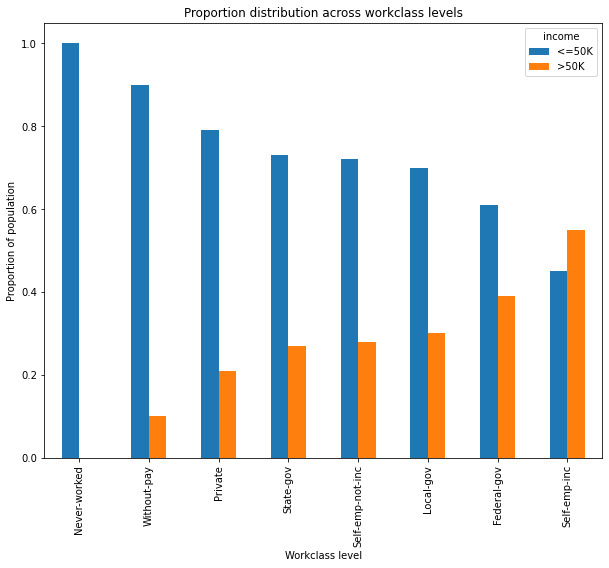

In [17]:
printmd('## 2.4. Workclass vs Income')

workclass = round(pd.crosstab(adult.workclass, adult.income).div(pd.crosstab(adult.workclass, adult.income).apply(sum,1),0),2)
workclass.sort_values(by = '>50K', inplace = True)
ax = workclass.plot(kind ='bar', title = 'Proportion distribution across workclass levels', figsize = (10,8))
ax.set_xlabel('Workclass level')
ax.set_ylabel('Proportion of population')

print()

## 2.5. Race vs Income

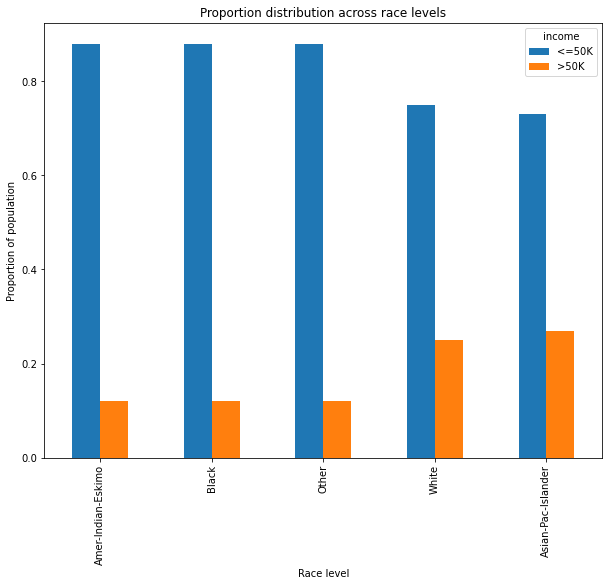

In [18]:
printmd('## 2.5. Race vs Income')

race = round(pd.crosstab(adult.race, adult.income).div(pd.crosstab(adult.race, adult.income).apply(sum,1),0),2)
race.sort_values(by = '>50K', inplace = True)

ax = race.plot(kind ='bar', title = 'Proportion distribution across race levels', figsize = (10,8))
ax.set_xlabel('Race level')
ax.set_ylabel('Proportion of population')

print()

## 2.6. Native Country

I plot a bar graph showing the proportion of income classes across the native country in figure         below. From the graph, we notice a trend in positioning of the country. South American country are         at the left end of the plot, with low proportion of population that make more than 50k a year. The         United States is located somewhat centrally, and at the right are countries from Europe and Asia,         with higher proportion of population that make more than 50k a year.

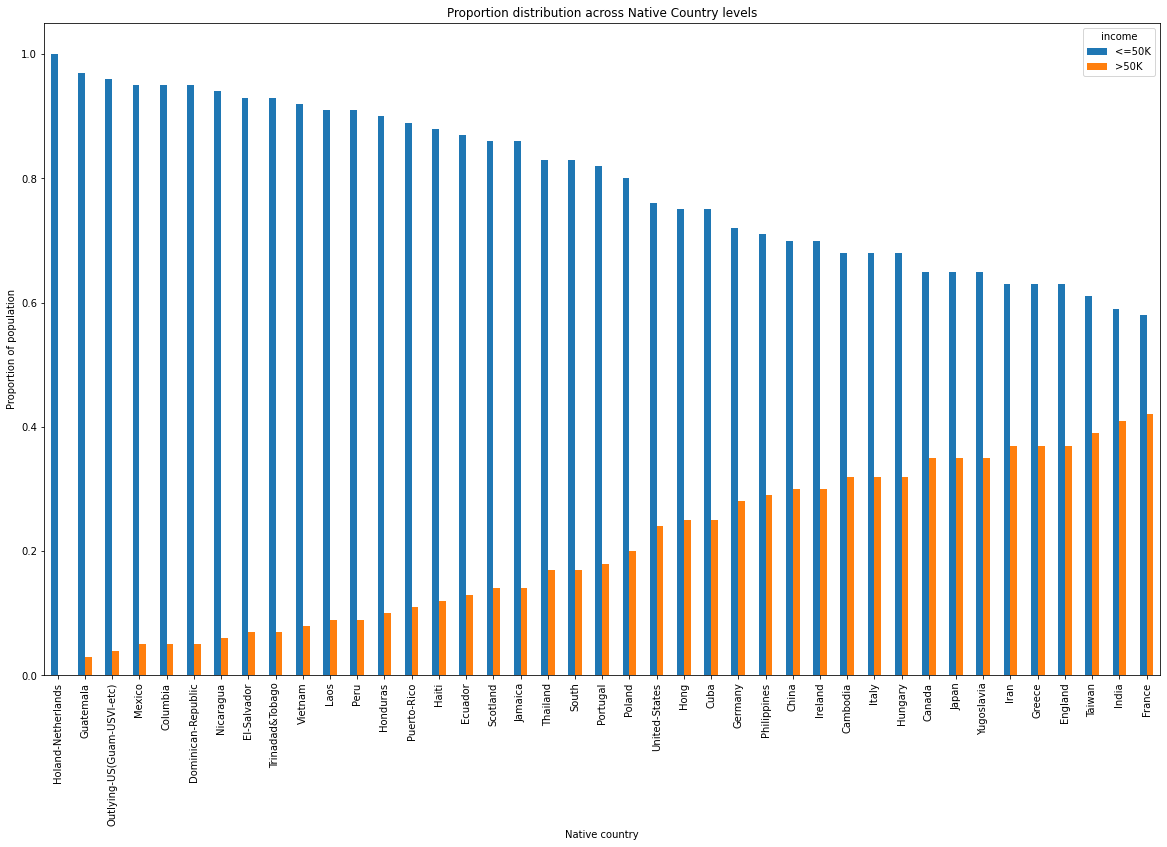

In [19]:
printmd('## 2.6. Native Country')

native_country = round(pd.crosstab(adult['native_country'], adult.income).div(pd.crosstab(adult['native_country'], adult.income).apply(sum,1),0),2)
native_country.sort_values(by = '>50K', inplace = True)

ax = native_country.plot(kind ='bar', title = 'Proportion distribution across Native Country levels', figsize = (20,12))
ax.set_xlabel('Native country')
ax.set_ylabel('Proportion of population')

printmd('I plot a bar graph showing the proportion of income classes across the native country in figure \
        below. From the graph, we notice a trend in positioning of the country. South American country are \
        at the left end of the plot, with low proportion of population that make more than 50k a year. The \
        United States is located somewhat centrally, and at the right are countries from Europe and Asia, \
        with higher proportion of population that make more than 50k a year.')

## 2.7. Hours per week vs Income

I plot a bar graph showing the proportion of income classes across the hours worked.         We would expected to notice a trend that higher the hours worked per week, the higher the proportion         of population making more than 50k a year. However, this was not necessarily true from the graph.         For several hours instance (for example, where hours worked was 77, 79, 81, 82, 87, 88 and so on)         no one earned more than 50k a year. 

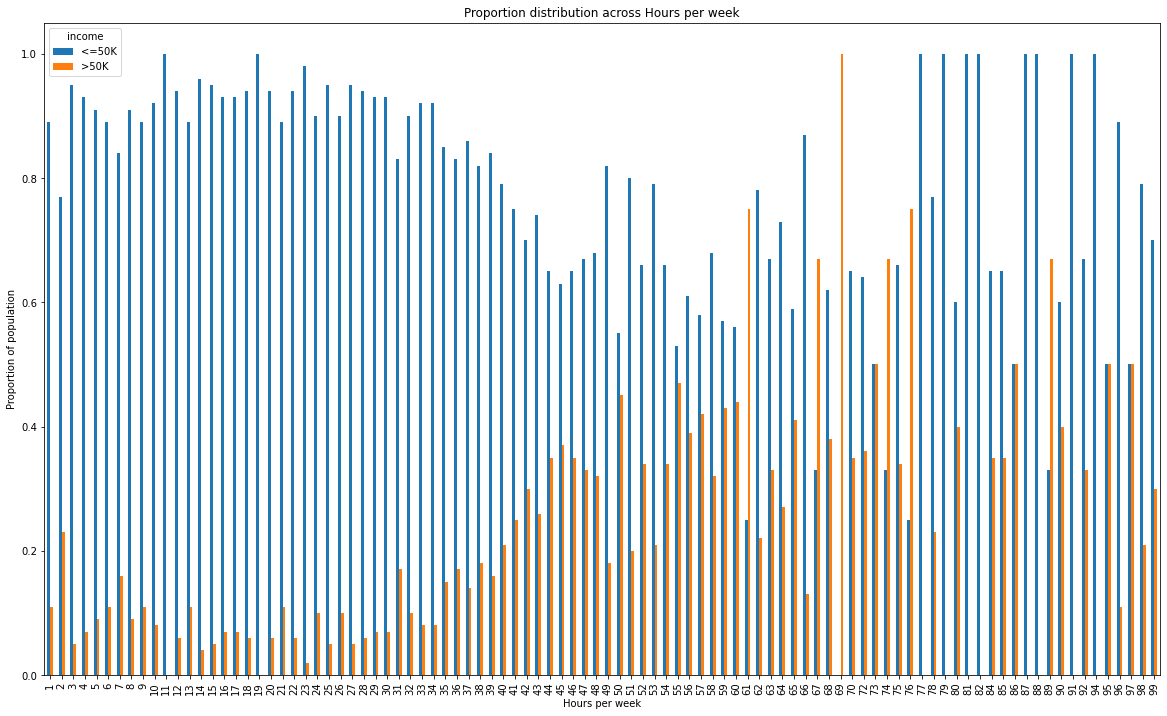

In [20]:
printmd('## 2.7. Hours per week vs Income')

hours_per_week = round(pd.crosstab(adult['hours_per_week'], adult.income).div(pd.crosstab(adult['hours_per_week'], adult.income).apply(sum,1),0),2)
#hours_per_week.sort_values(by = '>50K', inplace = True)

ax = hours_per_week.plot(kind ='bar', title = 'Proportion distribution across Hours per week', figsize = (20,12))
ax.set_xlabel('Hours per week')
ax.set_ylabel('Proportion of population')

printmd('I plot a bar graph showing the proportion of income classes across the hours worked. \
        We would expected to notice a trend that higher the hours worked per week, the higher the proportion \
        of population making more than 50k a year. However, this was not necessarily true from the graph. \
        For several hours instance (for example, where hours worked was 77, 79, 81, 82, 87, 88 and so on) \
        no one earned more than 50k a year. ')

### 2.7.1 Hours per week with categories

Therefore, I decided to transform this column into 3 categories, less than 40 hours,         40 to 60 hours and greater than 60 hours. Plotting a bar graph with these 3 categories,         we can see from the figure below that there is an increasing trend in the proportion of         population making more than 50k a year.

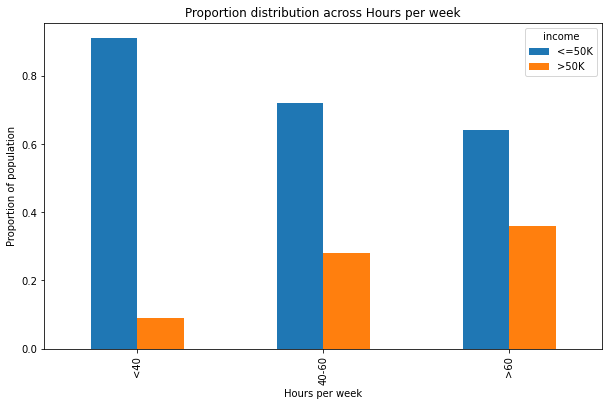

In [21]:
printmd('### 2.7.1 Hours per week with categories')

adult['hour_worked_bins'] = ['<40' if i < 40 else '40-60' if i <= 60 else '>60'  for i in adult['hours_per_week']]
adult['hour_worked_bins'] = adult['hour_worked_bins'].astype('category')

hours_per_week = round(pd.crosstab(adult.hour_worked_bins, adult.income).div(pd.crosstab(adult.hour_worked_bins, adult.income).apply(sum,1),0),2)
hours_per_week.sort_values(by = '>50K', inplace = True)

ax = hours_per_week.plot(kind ='bar', title = 'Proportion distribution across Hours per week', figsize = (10,6))
ax.set_xlabel('Hours per week')
ax.set_ylabel('Proportion of population')

printmd('Therefore, I decided to transform this column into 3 categories, less than 40 hours, \
        40 to 60 hours and greater than 60 hours. Plotting a bar graph with these 3 categories, \
        we can see from the figure below that there is an increasing trend in the proportion of \
        population making more than 50k a year.')

### 2.7.2 Hours worked across working classes

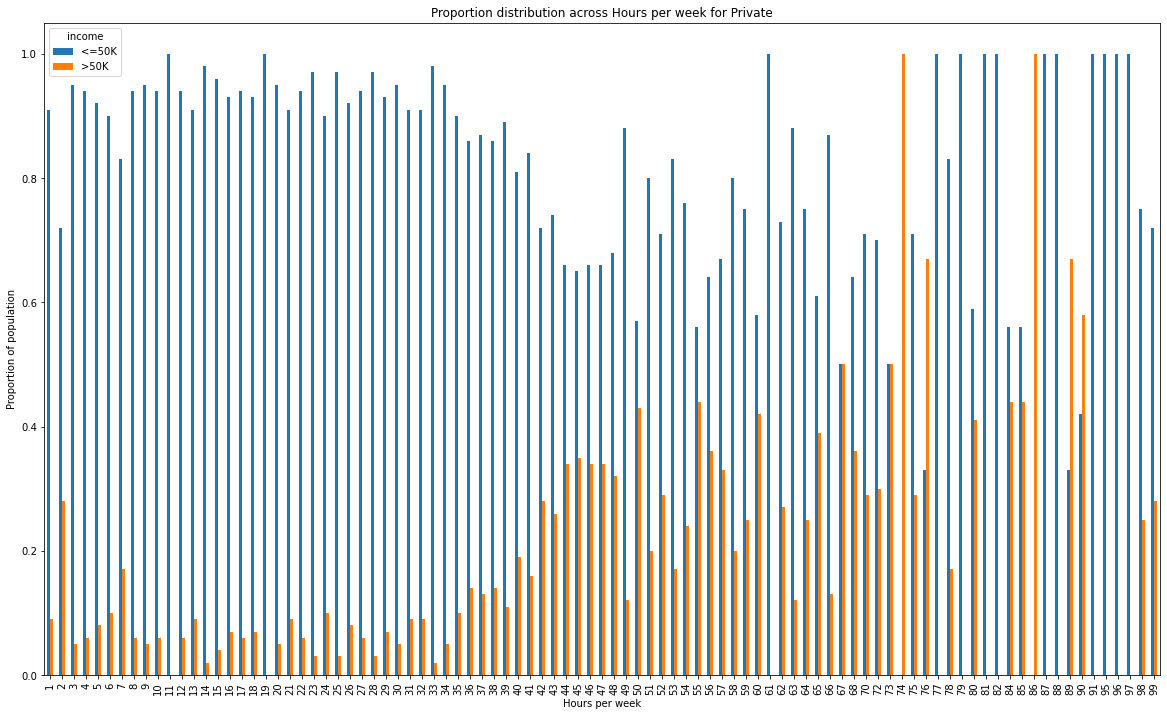

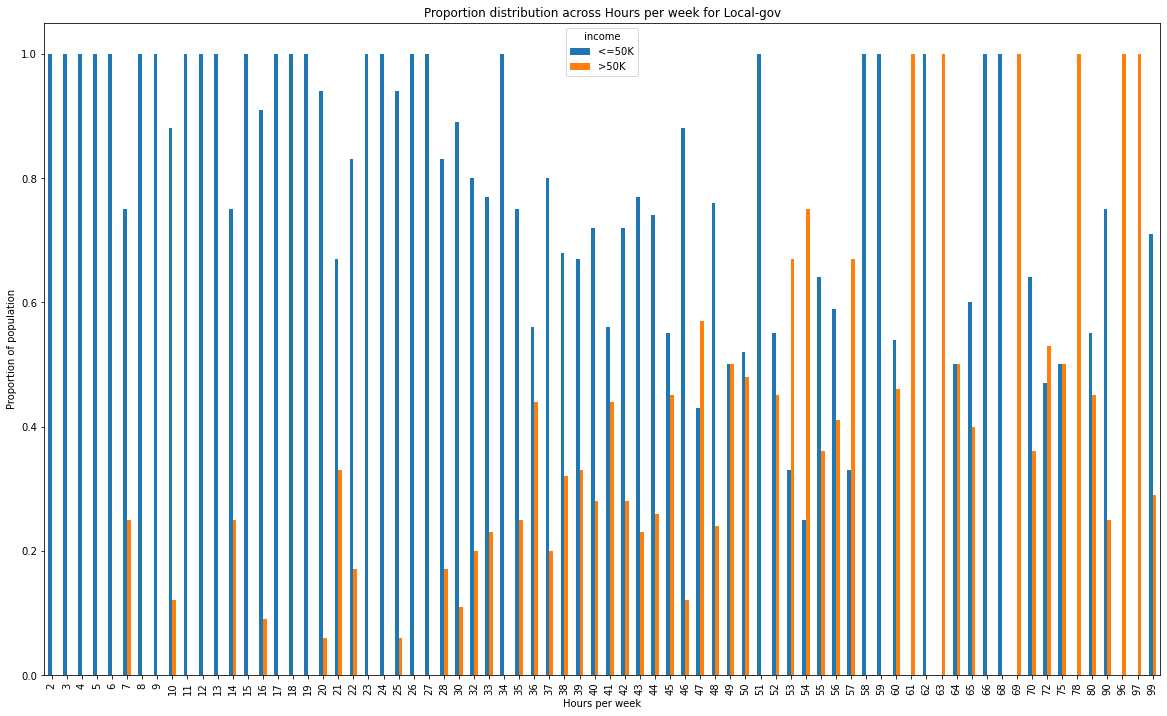

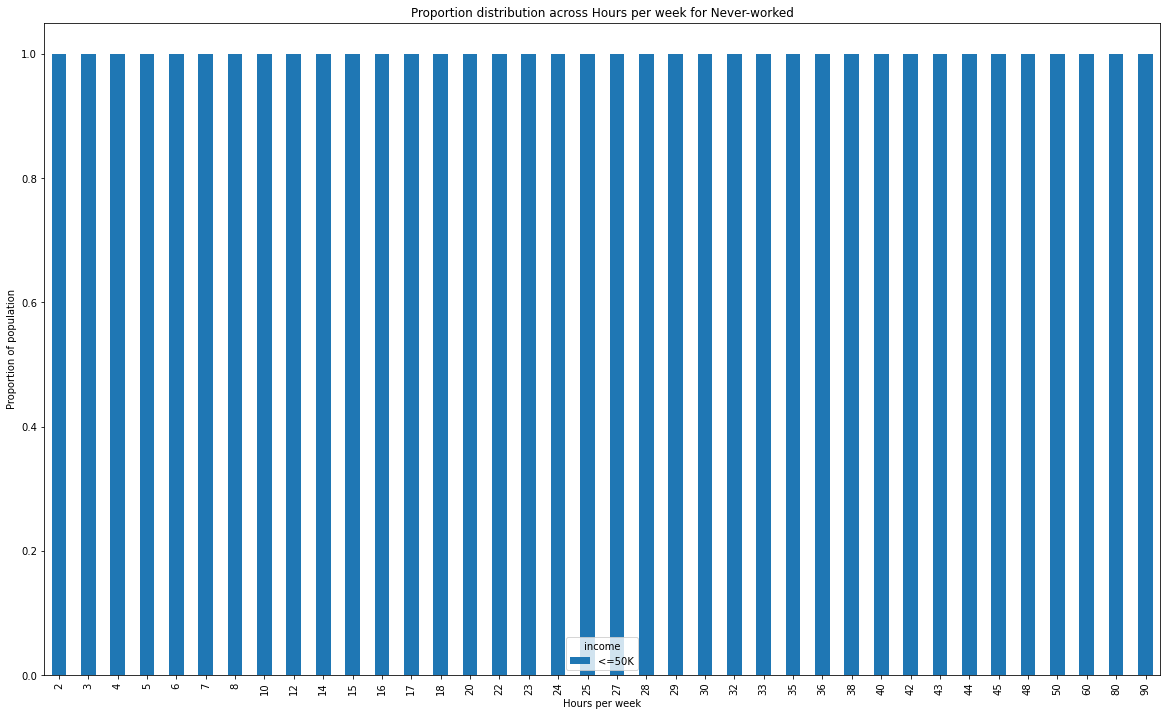

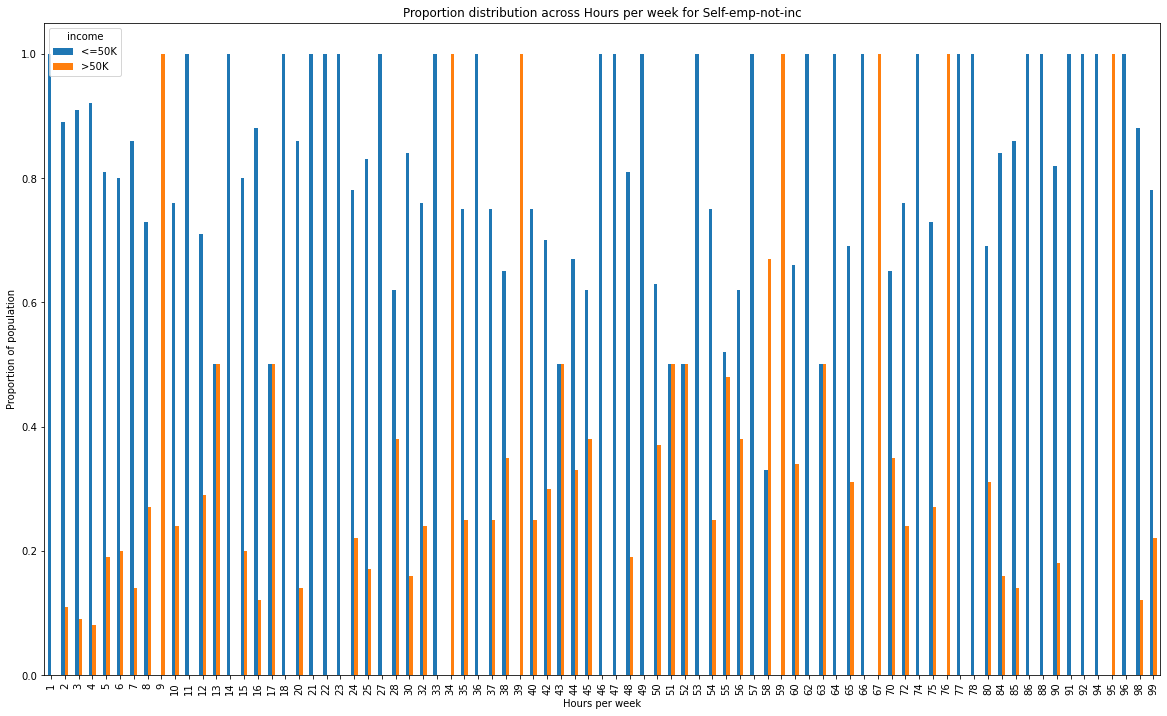

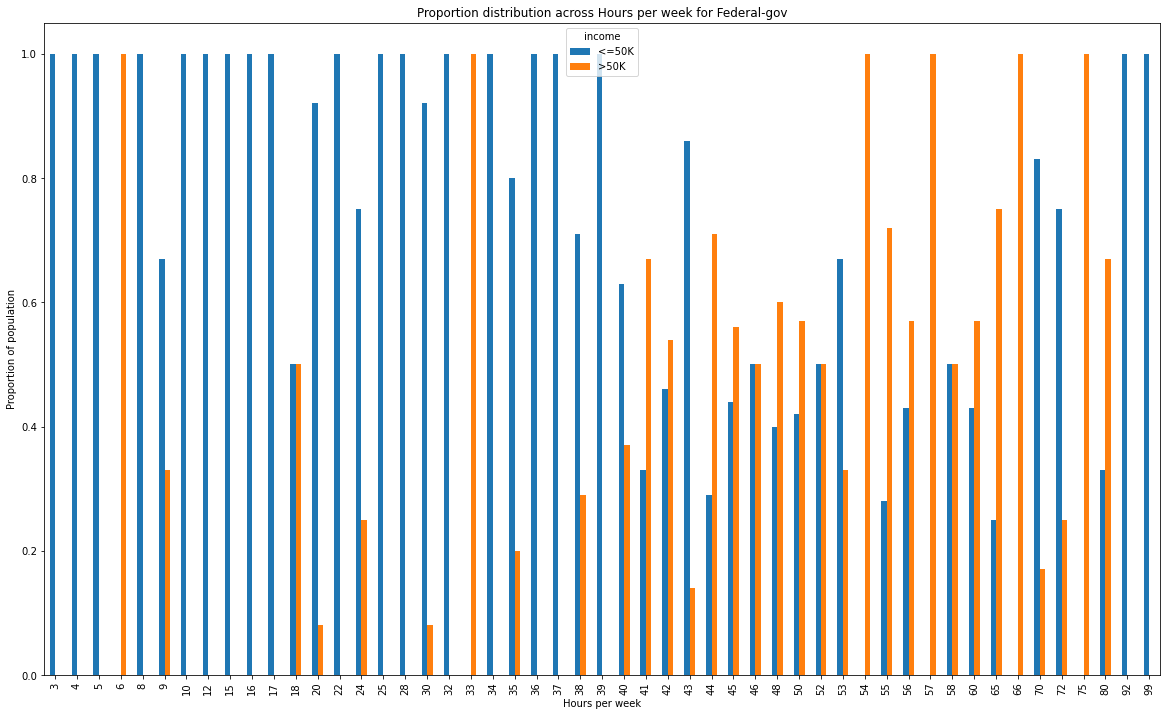

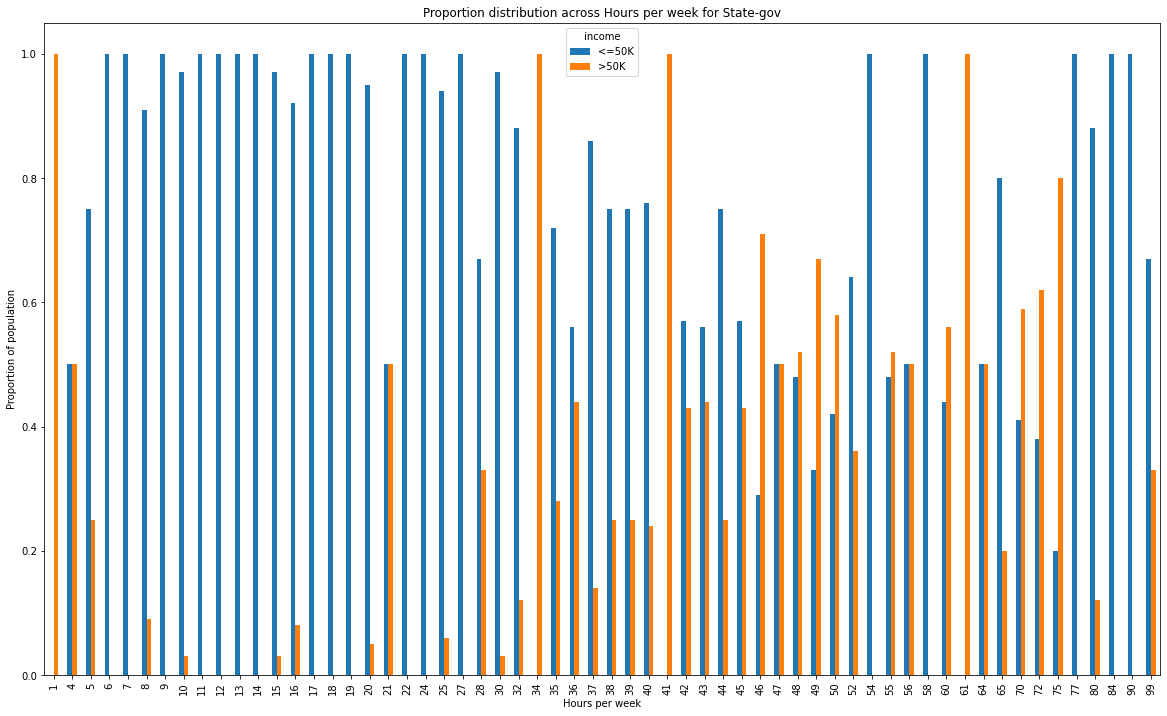

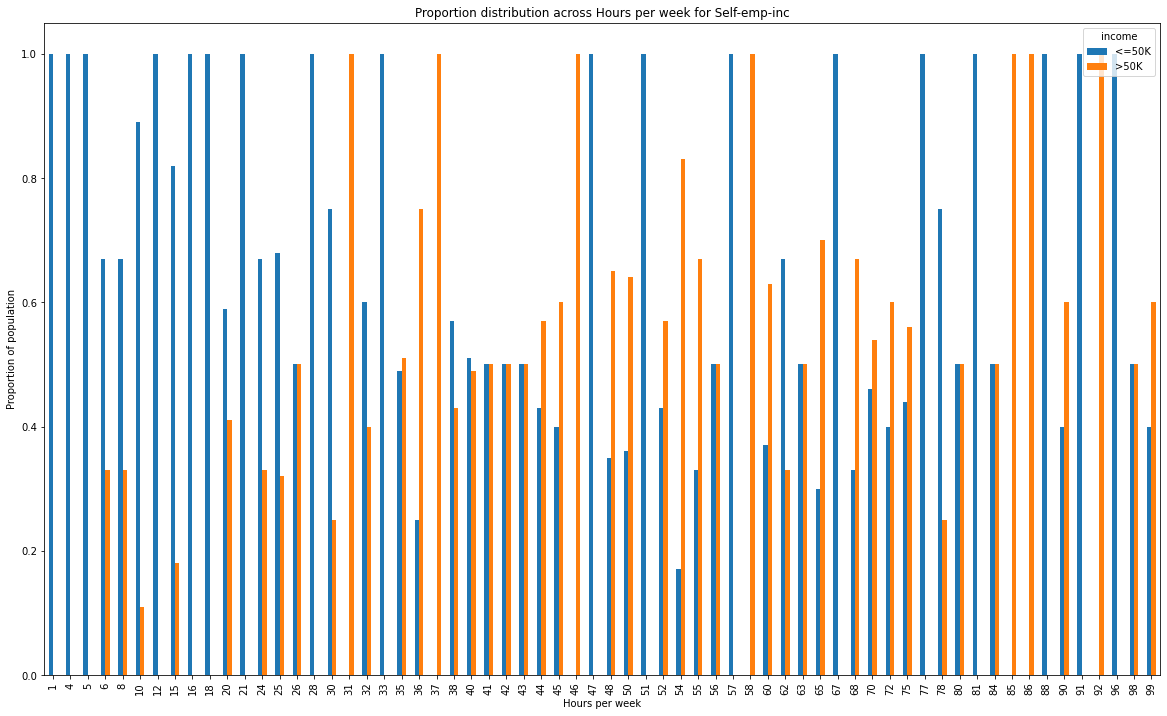

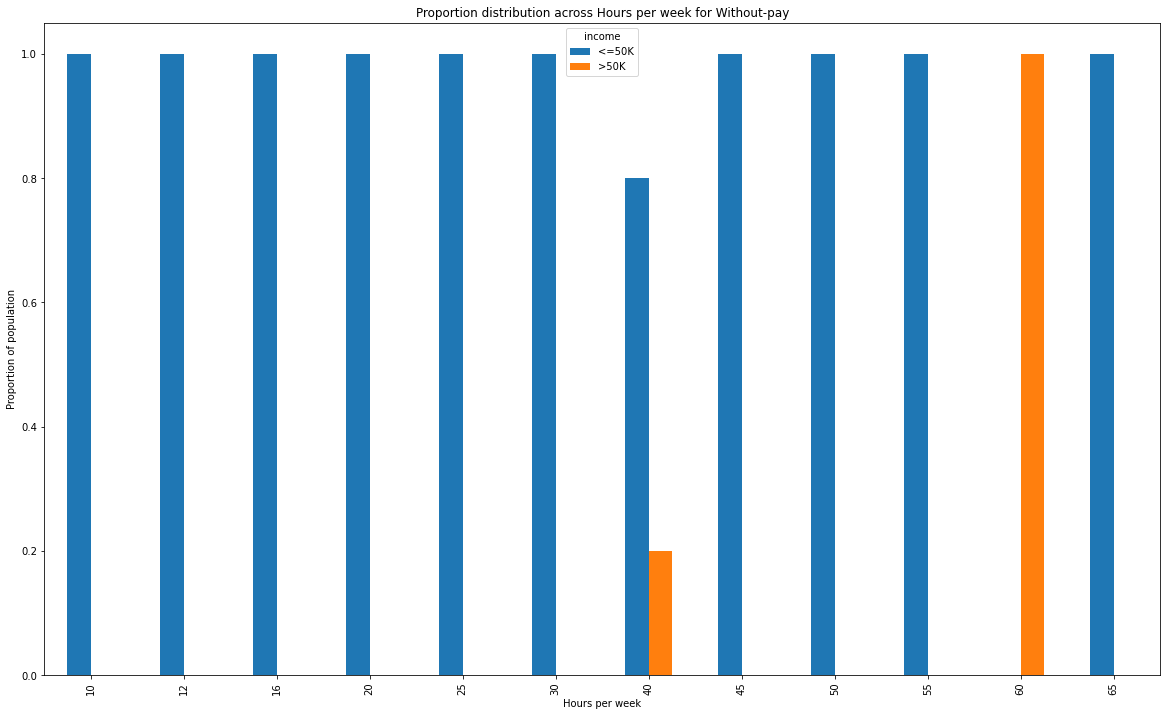

In [22]:
printmd('### 2.7.2 Hours worked across working classes')

for i in adult.workclass.unique():
    df = adult[adult.workclass == i]

    hours_per_week = round(pd.crosstab(df['hours_per_week'], df.income).div(pd.crosstab(df['hours_per_week'], df.income).apply(sum,1),0),2)
    # hours_per_week.sort_values(by = '>50K', inplace = True)
    
    ax = hours_per_week.plot(kind ='bar', title = 'Proportion distribution across Hours per week for '+ i, figsize = (20,12))
    ax.set_xlabel('Hours per week')
    ax.set_ylabel('Proportion of population')

    print()

In [23]:
# Remove education and fnlwgt
#adult.drop(columns = ['education','fnlwgt','hours-per-week'], inplace = True)

printmd('* For education level, we have 2 features that convey the same meaning, \'education\' \
        and \'educational_num\'. To avoid the effect of this attribute on the models to be \
        overstated, I am not going to use the categorical education attribute.')
printmd('* I use the categorical Hours work column and drop the \'hour-per-week\' column')
printmd('* Also, I chose not to use the \'Fnlwgt\' attribute that is used by the census, \
        as the inverse of sampling fraction adjusted for non-response and over or under sampling \
        of particular groups. This attribute does not convey individual related meaning.')

* For education level, we have 2 features that convey the same meaning, 'education'         and 'educational_num'. To avoid the effect of this attribute on the models to be         overstated, I am not going to use the categorical education attribute.

* I use the categorical Hours work column and drop the 'hour-per-week' column

* Also, I chose not to use the 'Fnlwgt' attribute that is used by the census,         as the inverse of sampling fraction adjusted for non-response and over or under sampling         of particular groups. This attribute does not convey individual related meaning.

## Box plot

<AxesSubplot:>

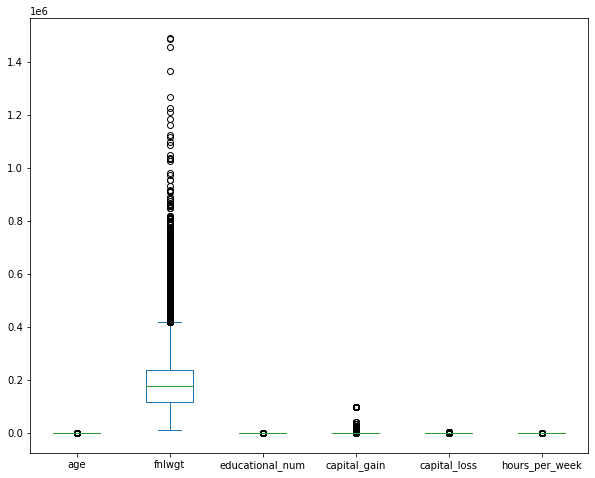

In [24]:
printmd('## Box plot')
adult.select_dtypes(exclude = 'category').plot(kind = 'box', figsize = (10,8))

In [25]:
printmd ('Normalization happens on the training dataset, by removing the mean and \
        scaling to unit variance. These values are stored and then later applied  \
        to the test data before the test data is passed to the model for prediction. ')

Normalization happens on the training dataset, by removing the mean and         scaling to unit variance. These values are stored and then later applied          to the test data before the test data is passed to the model for prediction. 

# Logistic Regression

## Sigmoid Function

In [26]:
def sigmoid(z):
    """
    Compute sigmoid function given the input z.
    
    Parameters
    ----------
    z : array_like
        The input to the sigmoid function. This can be a 1-D vector 
        or a 2-D matrix. 
    
    Returns
    -------
    g : array_like
        The computed sigmoid function. g has the same shape as z, since
        the sigmoid is computed element-wise on z.
        
    Instructions
    ------------
    Compute the sigmoid of each value of z (z can be a matrix, vector or scalar).
    """
    # convert input to a numpy array
    z = np.array(z)
    
    # You need to return the following variables correctly 
    g = np.zeros(z.shape)

    # ====================== YOUR CODE HERE ======================
    #if z<0.0001:
        #g = np.exp(z)/(1+np.exp(z))
    #else:
        #g = 1 / (1 + np.exp(-z))
    g = 1 / (1 + np.exp(-z))

    # =============================================================
    return g

## Predict Function

In [27]:
def predict(theta, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression.
    Computes the predictions for X using a threshold at 0.5 
    (i.e., if sigmoid(theta.T*x) >= 0.5, predict 1)
    
    Parameters
    ----------
    theta : array_like
        Parameters for logistic regression. A vecotor of shape (n+1, ).
    
    X : array_like
        The data to use for computing predictions. The rows is the number 
        of points to compute predictions, and columns is the number of
        features.

    Returns
    -------
    p : array_like
        Predictions and 0 or 1 for each row in X. 
    
    Instructions
    ------------
    Complete the following code to make predictions using your learned 
    logistic regression parameters.You should set p to a vector of 0's and 1's    
    """
    m = X.shape[0] # Number of training examples

    # You need to return the following variables correctly
    p = np.zeros(m)

    # ====================== YOUR CODE HERE ======================
    p = np.round(sigmoid(X.dot(theta.T)))
    
    #p = np.rint((sigmoid(X.dot(theta.T))))
    
    #p = np.rint(sigmoid(X.dot(theta.T)))
    #print(sigmoid(X.dot(theta.T)))
    
    # ============================================================
    return p

## Evaluation Function

In [28]:
def model_evaluation(actual, pred):
    
    confusion = pd.crosstab(actual, pred, rownames=['Actual'], colnames=['Predicted'])
    #print(confusion)
    TP = confusion.loc[1,1]
    TN = confusion.loc[0,0]
    FP = confusion.loc[0,1]
    FN = confusion.loc[1,0]
    
    

    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    
    out = {}
    out['accuracy'] =  accuracy
    out['precision'] = precision
    out['recall'] = recall
    out['f_measure'] = f_measure
    out['sensitivity'] = sensitivity
    out['specificity'] = specificity
    out['error_rate'] = error_rate
    
    return out

## Data Preparation

In [29]:
data_x = pd.read_csv('adult_processed_x.csv')
data_y= pd.read_csv('adult_processed_y.csv')

X= data_x.to_numpy()
print(X.shape)
print(X.dtype)

y = data_y.to_numpy()
print(y.shape)
print(y.dtype)

large_income=y[y==1].size
print('Total number of samples with income above 50K:\t%d' % large_income)
print('Total number of samples :\t\t\t%d' % y.size)

N = len(X)
N_train = int(0.5*N)      # The model  parameters for the network are adjusted using this set
N_val = int(0.25*N) # Use to tune parameters in the model. And avoid overfitting to the trainning set.  
N_test = N-N_train-N_val

# set random seed:
np.random.seed(0) 

# create a random permutation for splitting into training, validation and test
randperm = np.random.permutation(N)

# split into training and test
train_idx = randperm[:N_train]
val_idx = randperm[N_train:(N_train+N_val)]
test_idx = randperm[(N_train+N_val):]

Xtrain,Xval, Xtest = X[train_idx, :],X[val_idx, :], X[test_idx, :]
ytrain,yval, ytest = y[train_idx], y[val_idx] , y[test_idx]

print('Total number of samples:\t%d' % N)
print('Number of training samples:\t%d' % N_train)
print('Number of validation samples:\t%d' % N_val)
print('Number of test samples:\t%d' % N_test)
print(Xtrain.shape)
print(Xval.shape)
print(Xtest.shape)

print(ytrain.shape)
print(yval.shape)
print(ytest.shape)

print(ytrain.flatten())
print(yval.flatten())
print(ytest.flatten())

(32561, 88)
float64
(32561, 1)
int64
Total number of samples with income above 50K:	7841
Total number of samples :			32561
Total number of samples:	32561
Number of training samples:	16280
Number of validation samples:	8140
Number of test samples:	8141
(16280, 88)
(8140, 88)
(8141, 88)
(16280, 1)
(8140, 1)
(8141, 1)
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 1 0]
[1 1 0 ... 0 1 1]


## Intercept

In [30]:
# Setup the data matrix appropriately, and add ones for the intercept term
m, n = Xtrain.shape

# Add intercept term to X
#Xtrain = np.concatenate([np.ones((m, 1)), Xtrain], axis=1)

print(Xtrain.shape)

(16280, 88)


## Feature Mapping

In [31]:
# # Note that mapFeature also adds a column of ones for us, so the intercept
# # term is handled
#X = utils.mapFeature(X[:, 0], X[:, 1],degree=89)

#print(X.shape)



## Train-Test Split

In [32]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)


## Scaling

In [33]:
# Normalization
#from sklearn.preprocessing import StandardScaler  
#scaler = StandardScaler() 

# Fitting only on training data
#scaler.fit(Xtrain)  
#Xtrain = scaler.transform(Xtrain)  

# Applying same transformation to test data
#scaler.fit(X_test) 
#X_test = scaler.transform(X_test) 

In [34]:
print(ytrain[:,0].shape)

(16280,)


## Regularized Cost Function

In [35]:
def costFunctionReg(theta, X, y_in, lambda_):
    """
    Compute cost and gradient for logistic regression with regularization.
    
    Parameters
    ----------
    theta : array_like
        Logistic regression parameters. A vector with shape (n, ). n is 
        the number of features including any intercept. If we have mapped
        our initial features into polynomial features, then n is the total 
        number of polynomial features. 
    
    X : array_like
        The data set with shape (m x n). m is the number of examples, and
        n is the number of features (after feature mapping).
    
    y : array_like
        The data labels. A vector with shape (m, ).
    
    lambda_ : float
        The regularization parameter. 
    
    Returns
    -------
    J : float
        The computed value for the regularized cost function. 
    
    grad : array_like
        A vector of shape (n, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    
    Instructions
    ------------
    Compute the cost `J` of a particular choice of theta.
    Compute the partial derivatives and set `grad` to the partial
    derivatives of the cost w.r.t. each parameter in theta.
    """
    # Initialize some useful values
    m = y_in.size  # number of training examples

    # You need to return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    # ===================== YOUR CODE HERE ======================
    h = sigmoid(X.dot(theta.T))
    y=y_in[:,0]
    
    temp = theta
    temp[0] = 0
    
    pre=1e-8
    J = (1 / m) * np.sum(-y.dot(np.log(h + pre)) - (1 - y).dot(np.log(1 - h + pre))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))
    
    #J = (1 / m) * ((-y.dot(np.log(h)))-(1 - y).dot(np.log(1 - h)))+ ((lambda_ / (2 * m))* np.sum(np.square(temp)))
    grad = (1  /  m) * (h - y).dot(X) 
    grad = grad + (lambda_  /  m) * temp
    
    
    
    # =============================================================
    return J, grad

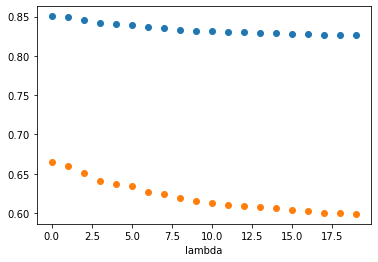




    lambda  accuracy  f1_scores
0      0.0  0.850491   0.665199
1      1.0  0.848894   0.659468
2      2.0  0.845946   0.650696
3      3.0  0.842506   0.640896
4      4.0  0.840786   0.637178
5      5.0  0.839066   0.633874
6      6.0  0.836364   0.626682
7      7.0  0.835504   0.623982
8      8.0  0.833538   0.618847
9      9.0  0.832310   0.615385
10    10.0  0.831695   0.612776
11    11.0  0.830958   0.610419
12    12.0  0.829975   0.608597
13    13.0  0.829361   0.607072
14    14.0  0.828747   0.605769
15    15.0  0.827887   0.603902
16    16.0  0.827518   0.602941
17    17.0  0.826536   0.599773
18    18.0  0.826658   0.599716
19    19.0  0.826290   0.598751


In [36]:
from sklearn.model_selection import KFold

# Initialize fitting parameters
initial_theta = np.zeros(Xtrain.shape[1])

# Initialize a list to store the cross-validation scores
accuracy_scores = []
lambda_scores = [] 
f_scores = []
# Iterate over a range of values for lambda
for lambda_ in np.arange(0.0, 20, 1):
    # Set options for optimize.minimize
    options= {'maxiter': 100}

    # Minimize the cost function using the current value of lambda
    res = optimize.minimize(costFunctionReg,
                            initial_theta,
                            (Xtrain, ytrain, lambda_),
                            jac=True,
                            method='TNC',
                            options=options)

    # Get the optimized theta from the result
    theta = res.x

    p = predict(theta, Xval)
    result = model_evaluation(yval[:,0], p)
    table = pd.DataFrame([result],index = ['result'])
    
    # Append 
    lambda_scores.append(lambda_)
    accuracy_scores.append(result['accuracy'])
    f_scores.append(result['f_measure'])
    #print(lambda_scores)
    #print(accuracy_scores)
    
import matplotlib.pyplot as plt

# plot y1 against x as a scatter plot
plt.scatter(lambda_scores, accuracy_scores)

# plot y2 against x as a scatter plot
plt.scatter(lambda_scores, f_scores)
plt.xlabel('lambda')
# show the plot
plt.show()

print('\n\n')
import pandas as pd

# Create a dictionary with the x and y values
data = {'lambda': lambda_scores, 'accuracy': accuracy_scores, 'f1_scores': f_scores}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Print the DataFrame
print(df)

In [37]:
# Turning off the warnings
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
#suppress warnings
np.warnings.filterwarnings('ignore')

# Initialize fitting parameters
initial_theta = np.zeros(Xtrain.shape[1])

# Set regularization parameter lambda to 1 (you should vary this)
lambda_ = 0.0

# set options for optimize.minimize
options= {'maxiter': 100}

res = optimize.minimize(costFunctionReg,
                        initial_theta,
                        (Xtrain, ytrain, lambda_),
                        jac=True,
                        method='TNC',
                        options=options)

# the fun property of OptimizeResult object returns
# the value of costFunction at optimized theta
cost = res.fun

# the optimized theta is in the x property of the result
theta = res.x

# Compute accuracy on our training set
p = predict(theta, Xtest)
print(p.astype(int))
print(len(p))
print('\n')
print(ytest.flatten())
print(len(ytest))
print('\n')
result = model_evaluation(ytest[:,0], p)
table = pd.DataFrame([result],index = ['result'])
display(table)

print('\n\n')
p = predict(theta, Xval)
print(p.astype(int))
print(len(p))
print('\n')
print(yval.flatten())
print(len(yval))
print('\n')
result = model_evaluation(yval[:,0], p)
table = pd.DataFrame([result],index = ['result'])
display(table)


[1 1 0 ... 0 1 1]
8141


[1 1 0 ... 0 1 1]
8141




,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
result,0.855669,0.738722,0.608673,0.667421,0.608673,0.932785,0.144331





[0 0 0 ... 0 1 1]
8140


[0 0 0 ... 0 1 0]
8140




,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
result,0.850491,0.733617,0.608455,0.665199,0.608455,0.928653,0.149509


In [38]:
cost,grad = costFunctionReg(theta, Xtrain, ytrain, 1)

In [39]:
print('Cost at theta: {:.3f}'.format(cost))

print('Gradient at theta - first 10 values only:')
print('\t[{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f},{:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}]\t'.format(*grad[:10]))

Cost at theta: 0.358
Gradient at theta - first 10 values only:
	[-0.0000, 0.0001, 0.0003, 0.0001, 0.0019,0.0002, 0.0002, 0.0000, 0.0000, -0.0001]	


In [40]:
y_prediction=predict(theta, Xtest)
y_prediction = y_prediction.astype(int)
print(y_prediction)
print(ytest.astype(int).flatten())

print('\n\n')
y_prediction=predict(theta, Xval)
y_prediction = y_prediction.astype(int)
print(y_prediction)
print(yval.astype(int).flatten())

[1 1 0 ... 0 1 1]
[1 1 0 ... 0 1 1]



[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 0]


In [41]:
log_reg = LogisticRegression(penalty = 'l2', dual = False, tol = 1e-4, fit_intercept = True, 
                            solver = 'liblinear')
log_reg.fit(Xtrain, ytrain)
log_reg_pred = log_reg.predict(Xtest)
print(log_reg_pred)
print(len(log_reg_pred))
print('\n')
print(ytest.flatten())
print(len(ytest))
print('\n')
logistic_reg = model_evaluation(ytest.flatten(), log_reg_pred)
#print('Logistic Regression : %.2f percent.' % (round(logistic_reg['accuracy']*100,3)))

#printmd('### 3.5.2. Model Evaulation ')
ovl_logreg = round(pd.DataFrame([logistic_reg], index = ['logistic_reg']),6)
display(ovl_logreg)

print('\n\n')

log_reg_pred = log_reg.predict(Xval)
print('\n')
print(log_reg_pred)
print(len(log_reg_pred))
print('\n\n')
print(yval.flatten())
print(len(yval))
print('\n')
logistic_reg = model_evaluation(yval.flatten(), log_reg_pred)
#print('Logistic Regression : %.2f percent.' % (round(logistic_reg['accuracy']*100,3)))

#printmd('### 3.5.2. Model Evaulation ')
ovl_logreg = round(pd.DataFrame([logistic_reg], index = ['logistic_reg']),6)
display(ovl_logreg)

[1 1 0 ... 0 1 0]
8141


[1 1 0 ... 0 1 1]
8141




,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
logistic_reg,0.849036,0.727799,0.583893,0.647952,0.583893,0.931818,0.150964







[0 0 0 ... 0 1 1]
8140



[0 0 0 ... 0 1 0]
8140




,accuracy,precision,recall,f_measure,sensitivity,specificity,error_rate
logistic_reg,0.848771,0.732759,0.598893,0.659097,0.598893,0.929465,0.151229
